In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ========================================================
# = Parameters for plotting
# ========================================================
FONT_SIZE = 14
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE,
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')

# 1 Global Parameters

In [3]:
normalisation_method = 'max-min' # 'mean_std'

# 1 Read Data

In [4]:
## read data
df_trraw = pd.read_csv('dataset/preprocessed/train_daily_recurring_clipping_normal.csv')
df_ttraw = pd.read_csv('dataset/preprocessed/test_daily_recurring_clipping_normal.csv')
df_trnorm = pd.read_csv('dataset/preprocessed/stdnorm_train_daily_recurring_clipping_normal.csv')
df_ttnorm = pd.read_csv('dataset/preprocessed/stdnorm_test_daily_recurring_clipping_normal.csv')

# 2. Model Traning

## 2.1 Label Binarize

In [5]:
concern_fault = 'Recurring Underperformance'
df_trraw['Label'] = df_trraw['faultname']== concern_fault
df_trraw['Label'] = df_trraw['Label'].astype(int)
df_ttraw['Label'] = df_ttraw['faultname']== concern_fault
df_ttraw['Label'] = df_ttraw['Label'].astype(int)

df_trnorm['Label'] = df_trnorm['faultname']== concern_fault
df_trnorm['Label'] = df_trnorm['Label'].astype(int)
df_ttnorm['Label'] = df_ttnorm['faultname']== concern_fault
df_ttnorm['Label'] = df_ttnorm['Label'].astype(int)

df_trraw[df_trraw['Label']==1]
labelnum_mapping = {1: concern_fault, 0: 'Others'}
label_mapping = {concern_fault:1, 'Others': 0}

In [6]:
df_trraw_clearsky = df_trraw[df_trraw['ClearSky']!=False].copy()
df_trraw_clearsky.index = np.arange(len(df_trraw_clearsky))
df_trnorm_clearsky = df_trnorm[df_trnorm['ClearSky']!=False].copy()
df_trnorm_clearsky.index = np.arange(len(df_trnorm_clearsky))
print(concern_fault, len(df_trraw_clearsky[df_trraw_clearsky['Label']==1]))
print('Non-Recurring:', len(df_trraw_clearsky[df_trraw_clearsky['Label']==0]))

Recurring Underperformance 127
Non-Recurring: 170


In [7]:
df_ttraw_clearsky = df_ttraw[df_ttraw['ClearSky']!=False].copy()
df_ttraw_clearsky.index = np.arange(len(df_ttraw_clearsky))
df_ttnorm_clearsky = df_ttnorm[df_ttnorm['ClearSky']!=False].copy()
df_ttnorm_clearsky.index = np.arange(len(df_ttnorm_clearsky))
print(concern_fault, len(df_ttraw_clearsky[df_ttraw_clearsky['Label']==1]))
print('Non-recurring:', len(df_ttraw_clearsky[df_ttraw_clearsky['Label']==0]))

Recurring Underperformance 26
Non-recurring: 43


In [8]:
df_ttraw_clearsky.iloc[46:50, :]

,date,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,...,23:45:00,dcPvsize,faultID,faultname,MID,ClearSky,Mean_value,Std_value,Max_value,Label
46,2022-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,140000.0,L1F002,Generation Clipping,MNTR|295222,True,41180.208,25739.216021,78744.0,0
47,2022-10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,140000.0,L1F002,Generation Clipping,MNTR|295222,True,41180.208,25739.216021,78744.0,0
48,2022-10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,140000.0,L1F002,Generation Clipping,MNTR|295222,True,41180.208,25739.216021,78744.0,0
49,2022-11-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,20000.0,L1F002,Generation Clipping,MNTR|300720,True,8619.550,5320.741978,14796.0,0


## 2.2 Plot Functions

In [9]:

from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, confusion_matrix

In [10]:
def plt_confusion_matrix(y_test, y_pred):
    # Compute the confusion matrix
    labels = np.unique(y_test.values.tolist() + y_pred.tolist())
    print(labels)
    cm = confusion_matrix(y_test.values, y_pred, labels=labels)

    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    print(list(label_mapping.values()))
    print(list(label_mapping.keys()))
    plt.xticks(list(label_mapping.values()), list(label_mapping.keys()))
    plt.yticks(list(label_mapping.values()), list(label_mapping.keys()))
    plt.xticks(rotation=90)  
    # plt.yticks(rotation=90)  
    plt.show()

In [11]:
def cal_metrics(y_test, y_pred):
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

    f1 = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
    print('f1 score:', f1)

## 2.3 XGBoost

In [12]:
import xgboost as xgb

### 2.3.1 Without Smooth (simple normalization)

In [13]:
X_trnorm = df_trnorm_clearsky.iloc[:, 1:97].astype(float)
Y_trnorm = df_trnorm_clearsky['Label'].astype(float)
X_ttnorm = df_ttnorm_clearsky.iloc[:, 1:97].astype(float)
Y_ttnorm = df_ttnorm_clearsky['Label'].astype(float)

In [14]:
# Create and train the XGBoost model
class_weights = {0: 2, 1: 1, 2: 2}  # Adjust weights as needed
XGBmodel = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
XGBmodel.fit(X_trnorm, Y_trnorm)

XGBNy_pred = XGBmodel.predict(X_ttnorm)
XGBNy_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0], dtype=int32)

In [15]:
cal_metrics(Y_ttnorm, XGBNy_pred)

Accuracy: 0.7681159420289855
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.63      0.77        43
         1.0       0.62      1.00      0.76        26

    accuracy                           0.77        69
   macro avg       0.81      0.81      0.77        69
weighted avg       0.86      0.77      0.77        69

f1 score: 0.7680672268907563


[0. 1.]
[1, 0]
['Recurring Underperformance', 'Others']


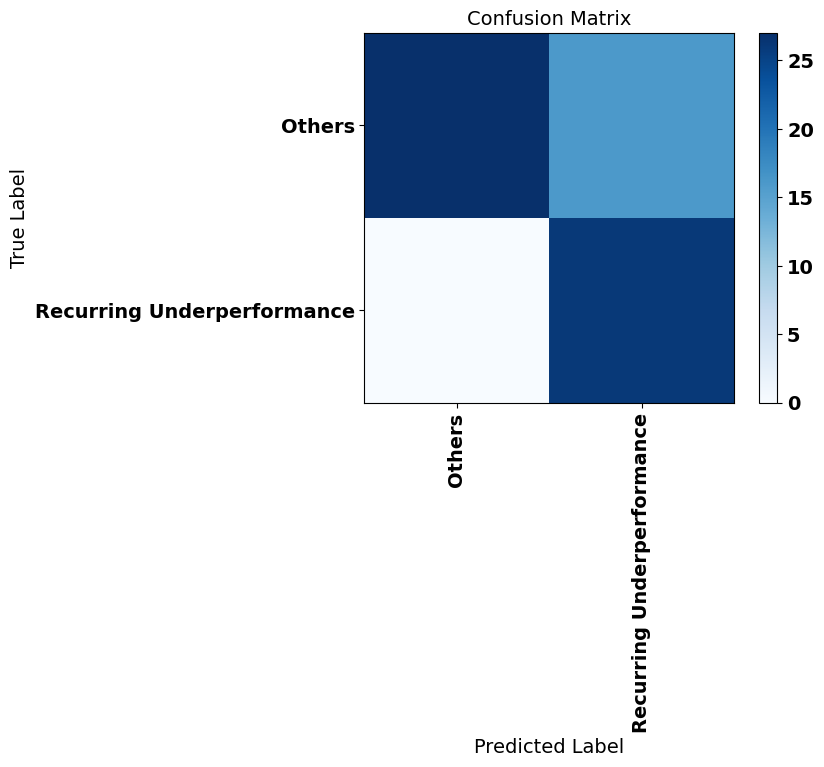

In [16]:
plt_confusion_matrix(Y_ttnorm, XGBNy_pred)

## 2.4 Linear SVC

### 2.4.1 Normalized method with SVC

In [17]:
from sklearn.svm import LinearSVC

SVCclassifier = LinearSVC(random_state=42)

# Train the classifier on the training data
SVCclassifier.fit(X_trnorm, Y_trnorm)

# Predict the labels for the test data
Ny_pred = SVCclassifier.predict(X_ttnorm)

# Evaluate the accuracy of the classifier
cal_metrics(Y_ttnorm, Ny_pred)


Accuracy: 0.7971014492753623
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.67      0.81        43
         1.0       0.65      1.00      0.79        26

    accuracy                           0.80        69
   macro avg       0.82      0.84      0.80        69
weighted avg       0.87      0.80      0.80        69

f1 score: 0.7967171717171717


## 2.5. KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=8)
# Train the model using the training data
knn.fit(X_trnorm, Y_trnorm)

# Make predictions on the testing data
Ny_pred = knn.predict(X_ttnorm)
cal_metrics(Y_ttnorm, Ny_pred)

Accuracy: 0.7536231884057971
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.60      0.75        43
         1.0       0.60      1.00      0.75        26

    accuracy                           0.75        69
   macro avg       0.80      0.80      0.75        69
weighted avg       0.85      0.75      0.75        69

f1 score: 0.7536231884057971


## 2.6. Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier()

# Train the classifier using the training data
clf.fit(X_trnorm, Y_trnorm)

# Make predictions on the testing data
Ny_pred = clf.predict(X_ttnorm)
cal_metrics(Y_ttnorm, Ny_pred)

Accuracy: 0.7536231884057971
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.67      0.77        43
         1.0       0.62      0.88      0.73        26

    accuracy                           0.75        69
   macro avg       0.76      0.78      0.75        69
weighted avg       0.80      0.75      0.76        69

f1 score: 0.7517460317460318


## 2.7. Random Forests

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100)

# Train the classifier using the training data
clf.fit(X_trnorm, Y_trnorm)

# Make predictions on the testing data
Ny_pred = clf.predict(X_ttnorm)

cal_metrics(Y_ttnorm, Ny_pred)

Accuracy: 0.9420289855072463
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        43
         1.0       0.87      1.00      0.93        26

    accuracy                           0.94        69
   macro avg       0.93      0.95      0.94        69
weighted avg       0.95      0.94      0.94        69

f1 score: 0.9398954703832754


# 3. Pick up the faulty points

In [23]:
# Select the misclassified samples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(Y_ttnorm, XGBNy_pred)) if true != pred]
print(misclassified_indices)
missclassified_result = pd.DataFrame(index=range(len(misclassified_indices)), columns=['True_Label', 'Pred_Label'])
for i in range(len(misclassified_indices)):
    missclassified_result.iloc[i, 0] = int(Y_ttnorm.iloc[misclassified_indices[i]])
    missclassified_result.iloc[i, 1] = int(XGBNy_pred[misclassified_indices[i]])
misX_indices = X_ttnorm.iloc[misclassified_indices, :].index.values
misclassified_samples = df_ttraw_clearsky.iloc[misX_indices, :].copy()
misclassified_samples['estimated_label'] = missclassified_result.iloc[:, 1].values
print('total test samples: {}, misclassified sample number: {}'.format(len(Y_ttnorm), len(misclassified_samples)))
misclassified_samples.head()


[46, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
total test samples: 69, misclassified sample number: 16


,date,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,...,dcPvsize,faultID,faultname,MID,ClearSky,Mean_value,Std_value,Max_value,Label,estimated_label
46,2022-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,140000.0,L1F002,Generation Clipping,MNTR|295222,True,41180.208,25739.216021,78744.0,0,1
49,2022-11-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20000.0,L1F002,Generation Clipping,MNTR|300720,True,8619.550,5320.741978,14796.0,0,1
50,2022-11-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20000.0,L1F002,Generation Clipping,MNTR|300720,True,8619.550,5320.741978,14796.0,0,1
51,2022-11-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20000.0,L1F002,Generation Clipping,MNTR|300720,True,8619.550,5320.741978,14796.0,0,1
52,2022-11-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20000.0,L1F002,Generation Clipping,MNTR|300720,True,8619.550,5320.741978,14796.0,0,1


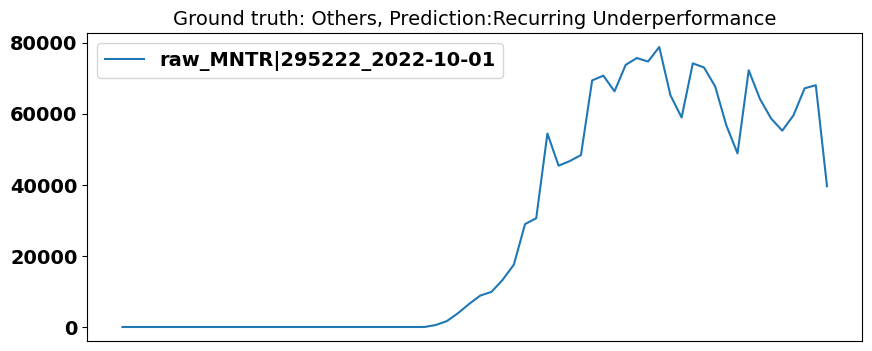

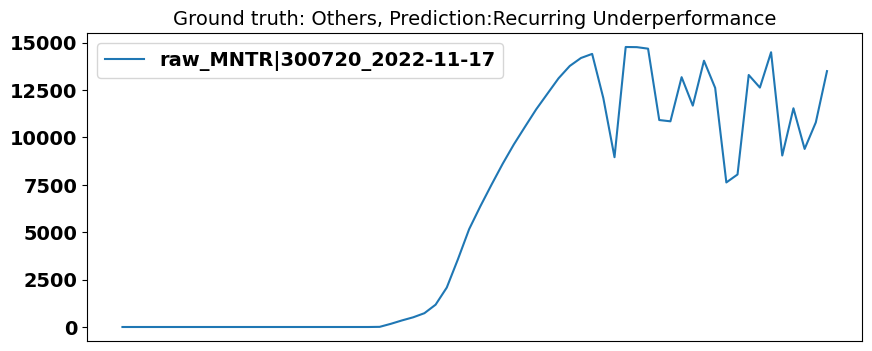

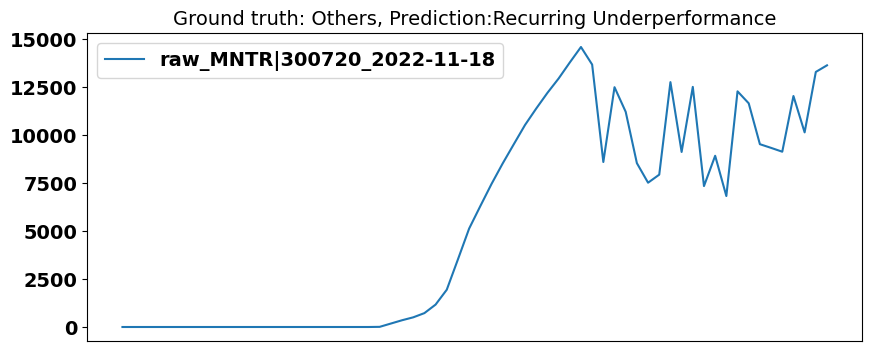

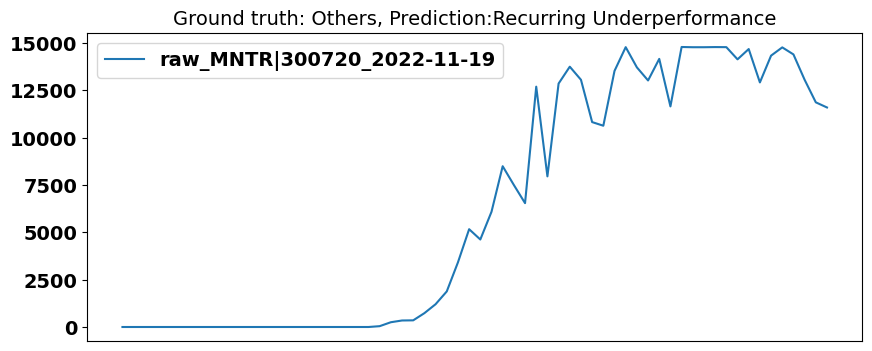

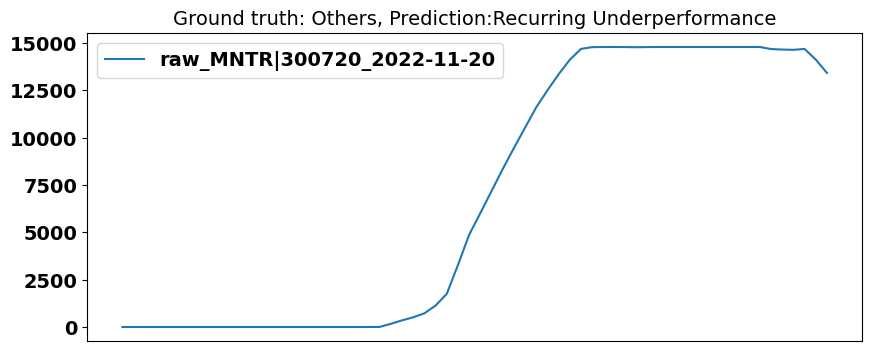

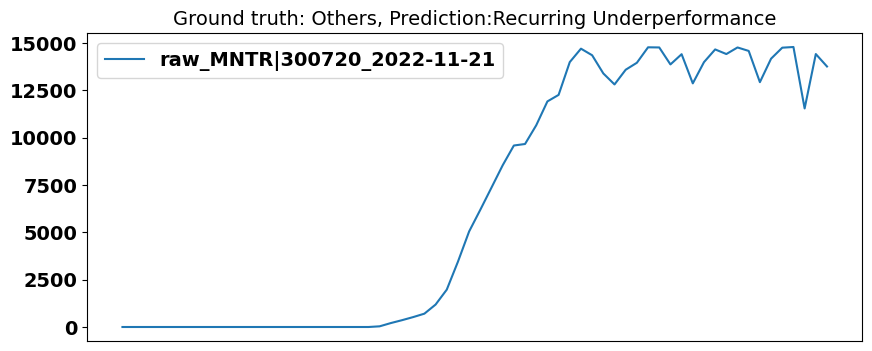

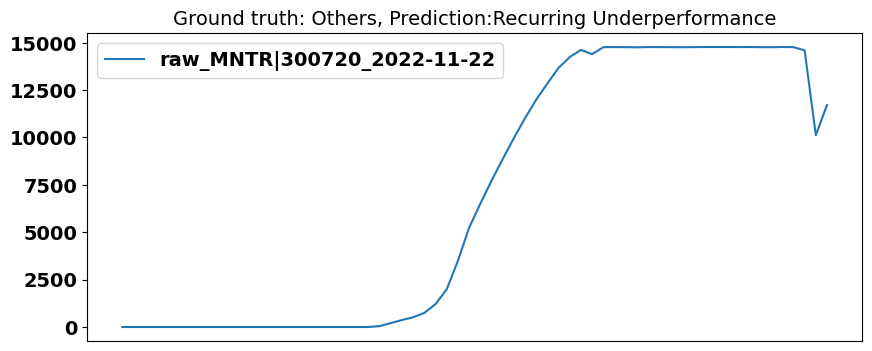

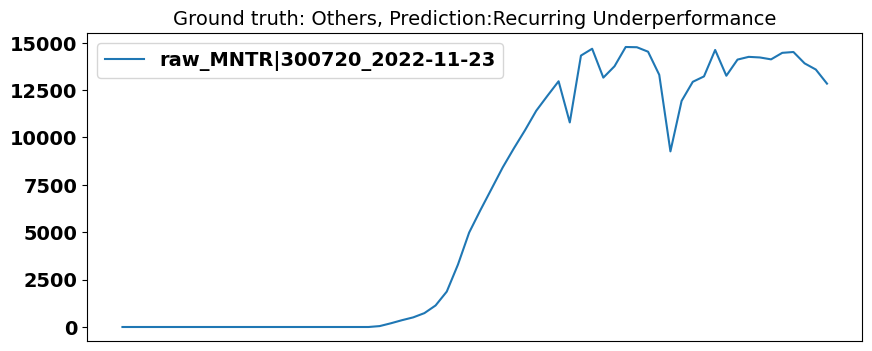

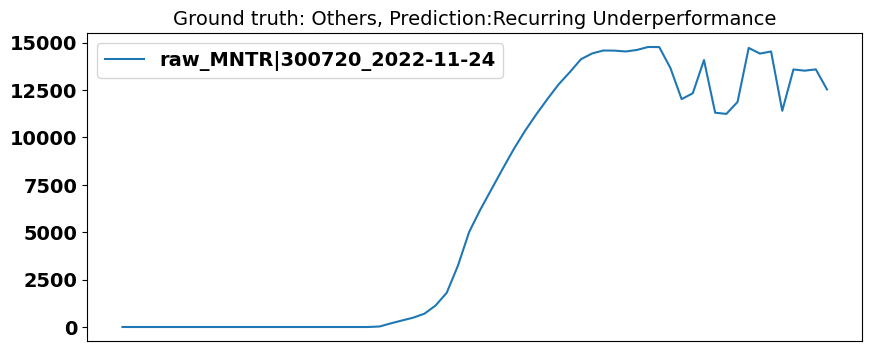

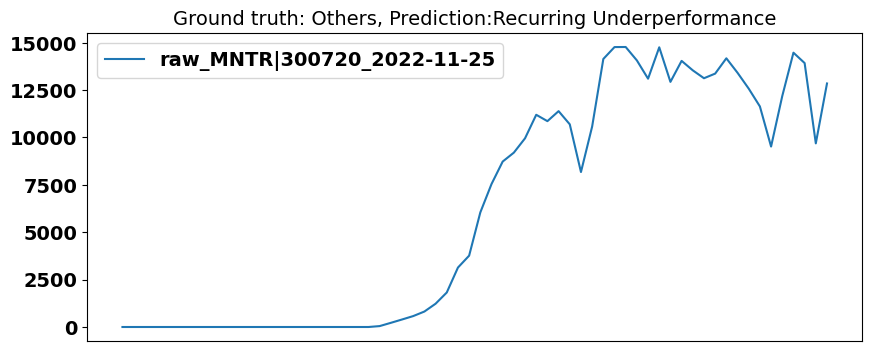

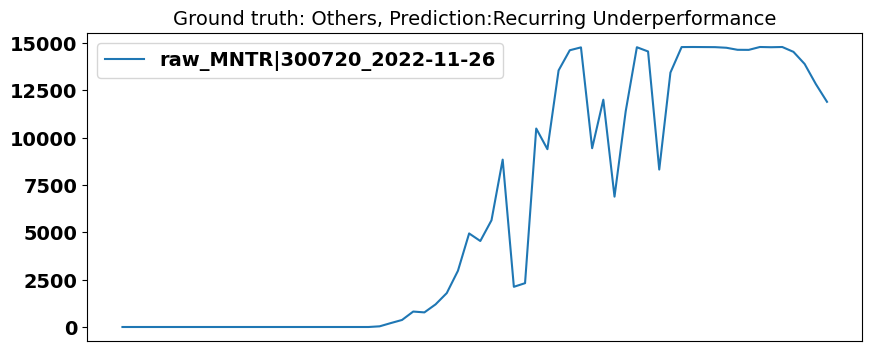

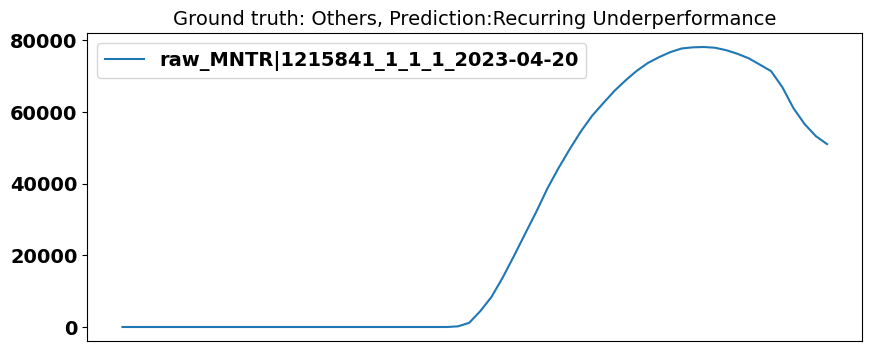

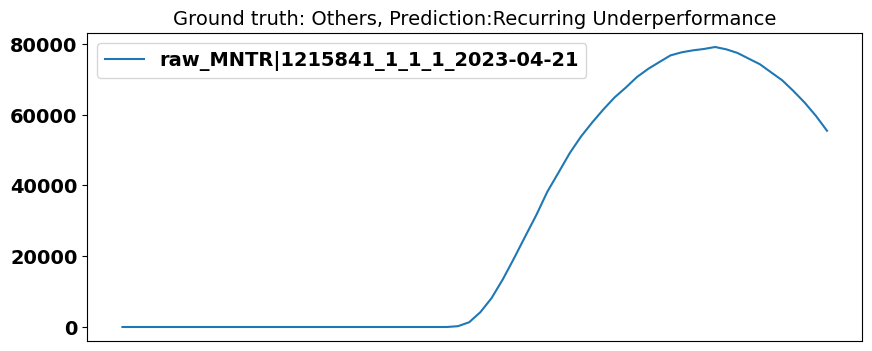

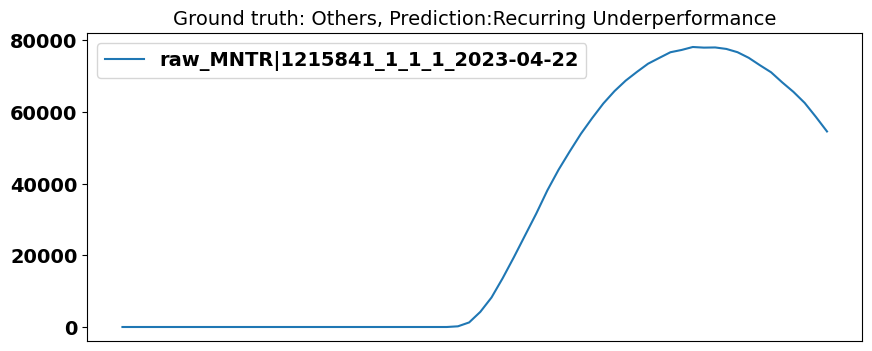

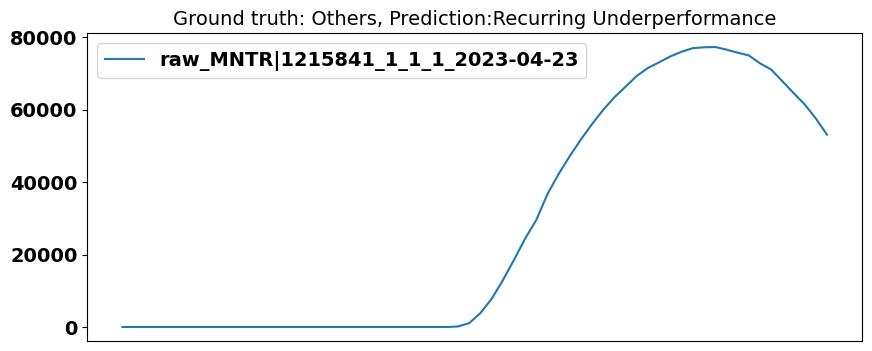

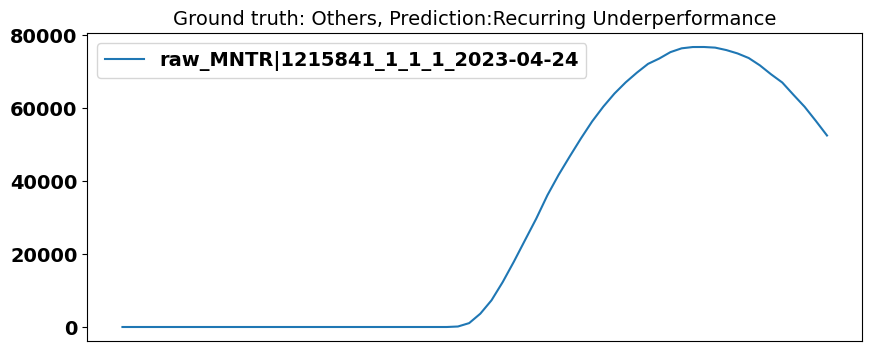

In [24]:

for i, idx in enumerate(misclassified_samples.index):
    fig, axes = plt.subplots(nrows=1, figsize=(10, 4))
    axes.plot(misclassified_samples.iloc[i, 1:65], label='raw_{}_{}'.format(misclassified_samples.iloc[i, :]['MID'], misclassified_samples.iloc[i, :]['date']))
    # axes[i].plot(df_ml_stl.iloc[idx, 1:65], label='stl')
    axes.set_title('Ground truth: {}, Prediction:{}'.format(labelnum_mapping[misclassified_samples.iloc[i,:]['Label']], labelnum_mapping[misclassified_samples.iloc[i, :]['estimated_label']]))
    axes.set_xticks([])
    axes.legend()